In [1]:
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from PIL import Image, ImageEnhance,ImageOps, ImageFilter

from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import os
import random

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
train_dir = '/kaggle/input/dataset1/brain-tumor-mri-dataset/Training/'
test_dir = '/kaggle/input/dataset1/brain-tumor-mri-dataset/Testing/'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

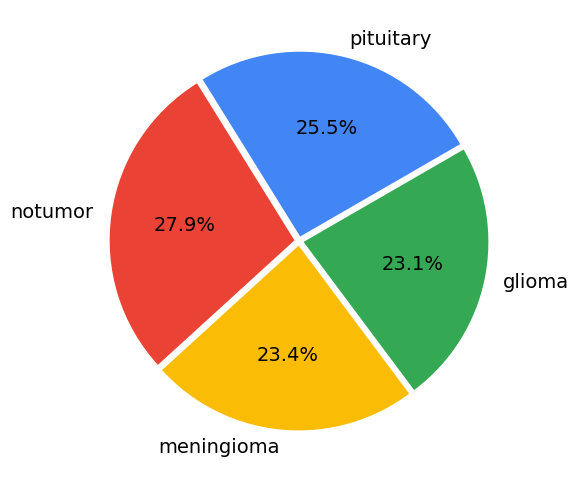

In [6]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len([x for x in train_labels if x=='pituitary']),
         len([x for x in train_labels if x=='notumor']),
         len([x for x in train_labels if x=='meningioma']),
         len([x for x in train_labels if x=='glioma'])],
        labels=['pituitary','notumor', 'meningioma', 'glioma'],
        colors=colors, autopct='%.1f%%', explode=(0.025,0.025,0.025,0.025),
        startangle=30);

In [7]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

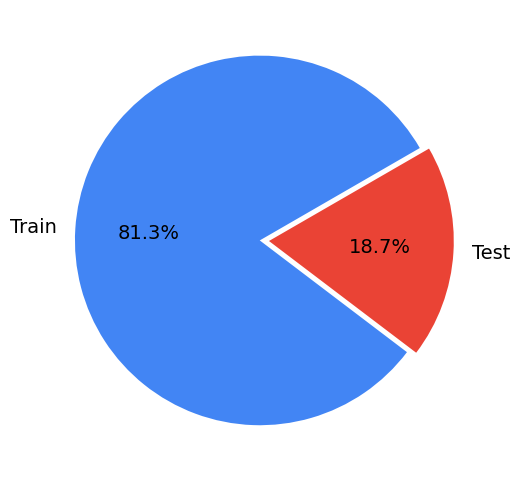

In [8]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

In [9]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    
    brightness_factor = random.uniform(0.8, 1.2)
    image = ImageEnhance.Brightness(image).enhance(brightness_factor)
    
    contrast_factor = random.uniform(0.8, 1.2)
    image = ImageEnhance.Contrast(image).enhance(contrast_factor)
    
    if random.random() < 0.5:
        image = image.transpose(Image.FLIP_LEFT_RIGHT)
    
    if random.random() < 0.5:
        image = image.transpose(Image.FLIP_TOP_BOTTOM)
    
    rotation_angle = random.uniform(-10, 10)  # in degrees
    image = image.rotate(rotation_angle)
    
    shear_factor = random.uniform(-0.2, 0.2)
    image = image.transform(image.size, Image.AFFINE, (1, shear_factor, 0, 0, 1, 0))
    
    crop_ratio = random.uniform(0.8, 1.0)
    image = ImageOps.crop(image, (image.width * (1 - crop_ratio)) // 2)
    
    if random.random() < 0.5:
        image = image.filter(ImageFilter.GaussianBlur(radius=random.uniform(0, 1)))

    image = np.array(image) / 255.0
    return image


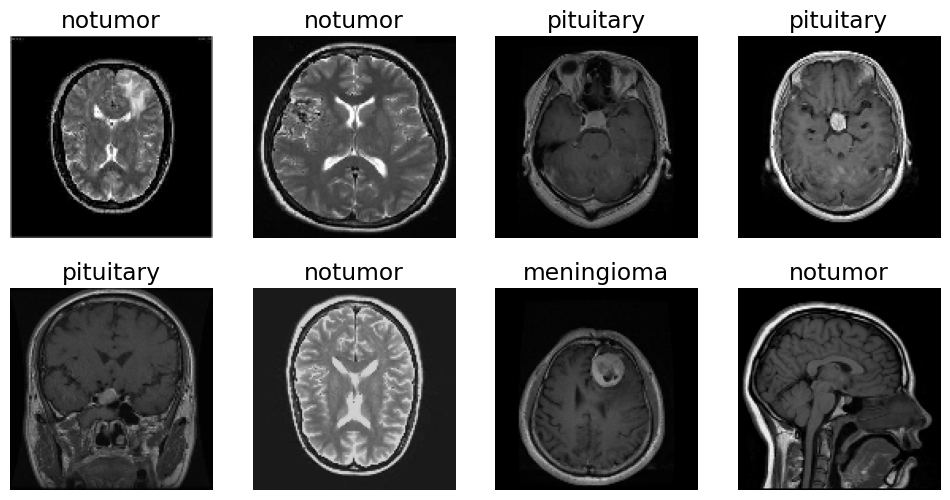

In [10]:
IMAGE_SIZE = 128

def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

In [11]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

In [12]:
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

58889256/58889256 [==============================] - 0s 0us/step


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 15,763,908
Trainable params: 8,128,644
Non

In [14]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [17]:
batch_size = 32
steps = int(len(train_paths)/batch_size)
epochs = 25
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/25
178/178 [==============================] - 54s 232ms/step - loss: 0.4543 - sparse_categorical_accuracy: 0.8209
Epoch 2/25
178/178 [==============================] - 20s 103ms/step - loss: 0.2343 - sparse_categorical_accuracy: 0.9121
Epoch 3/25
178/178 [==============================] - 19s 106ms/step - loss: 0.1533 - sparse_categorical_accuracy: 0.9401
Epoch 4/25
178/178 [==============================] - 19s 106ms/step - loss: 0.1103 - sparse_categorical_accuracy: 0.9570
Epoch 5/25
178/178 [==============================] - 19s 108ms/step - loss: 0.0911 - sparse_categorical_accuracy: 0.9660
Epoch 6/25
178/178 [==============================] - 19s 106ms/step - loss: 0.0747 - sparse_categorical_accuracy: 0.9727
Epoch 7/25
178/178 [==============================] - 20s 111ms/step - loss: 0.0546 - sparse_categorical_accuracy: 0.9790
Epoch 8/25
178/178 [==============================] - 22s 122ms/step - loss: 0.0487 - sparse_categorical_accuracy: 0.9822
Epoch 9/25
178/178 [====

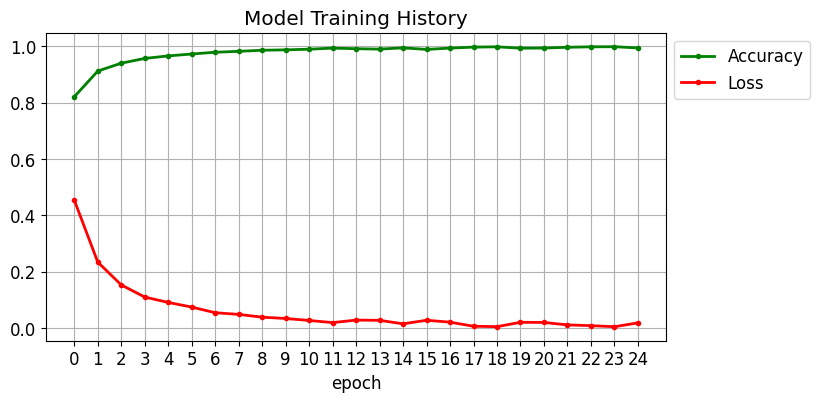

In [18]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


In [19]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 0s 200ms/step


  2%|▎         | 1/40 [00:00<00:18,  2.08it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 2/40 [00:00<00:14,  2.65it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 3/40 [00:01<00:12,  2.98it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 4/40 [00:01<00:11,  3.09it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▎        | 5/40 [00:01<00:10,  3.18it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 6/40 [00:01<00:10,  3.20it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 7/40 [00:02<00:10,  3.25it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 8/40 [00:02<00:09,  3.25it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▎       | 9/40 [00:02<00:09,  3.27it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 10/40 [00:03<00:09,  3.28it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 11/40 [00:03<00:08,  3.32it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 12/40 [00:03<00:08,  3.32it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▎      | 13/40 [00:04<00:08,  3.36it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 14/40 [00:04<00:07,  3.32it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 15/40 [00:04<00:07,  3.33it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 16/40 [00:04<00:07,  3.35it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▎     | 17/40 [00:05<00:06,  3.35it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 18/40 [00:05<00:06,  3.36it/s]

1/1 [==============================] - 0s 59ms/step


 48%|████▊     | 19/40 [00:05<00:06,  3.27it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 20/40 [00:06<00:06,  3.12it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▎    | 21/40 [00:06<00:06,  3.06it/s]

1/1 [==============================] - 0s 72ms/step


 55%|█████▌    | 22/40 [00:07<00:06,  2.78it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▊    | 23/40 [00:07<00:05,  2.84it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 24/40 [00:07<00:05,  2.98it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▎   | 25/40 [00:07<00:04,  3.05it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 26/40 [00:08<00:04,  3.12it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 27/40 [00:08<00:04,  3.19it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 28/40 [00:08<00:03,  3.21it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▎  | 29/40 [00:09<00:03,  3.23it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 30/40 [00:09<00:03,  3.19it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 31/40 [00:09<00:02,  3.23it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 32/40 [00:10<00:02,  3.21it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▎ | 33/40 [00:10<00:02,  3.28it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 34/40 [00:10<00:01,  3.32it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 35/40 [00:11<00:01,  3.28it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 36/40 [00:11<00:01,  3.28it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▎| 37/40 [00:11<00:00,  3.29it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 38/40 [00:11<00:00,  3.31it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 39/40 [00:12<00:00,  3.33it/s]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 40/40 [00:12<00:00,  3.33it/s]

1/1 [==============================] - 3s 3s/step


41it [00:15,  2.65it/s]                        


In [20]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      glioma       0.97      0.96      0.96       300
  meningioma       0.95      0.95      0.95       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.98      0.99      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



In [21]:
cm = confusion_matrix(test_labels,y_pred) 

In [22]:
cm

array([[287,  13,   0,   0],
       [  7, 292,   1,   6],
       [  0,   0, 405,   0],
       [  2,   1,   0, 297]])

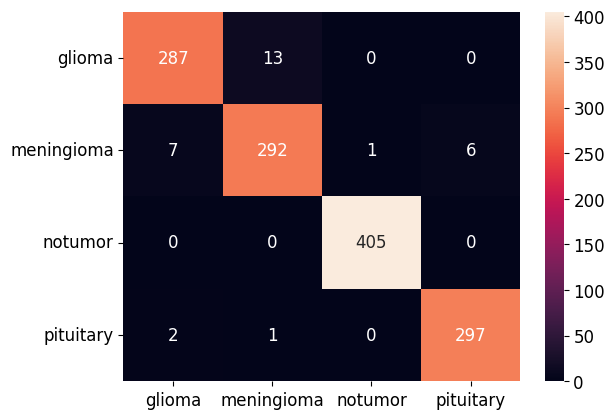

In [23]:
x_axis_labels = ['glioma','meningioma','notumor','pituitary'] 
y_axis_labels = ['glioma','meningioma','notumor','pituitary'] 

plt.figure()
sns.heatmap(cm, xticklabels=x_axis_labels, yticklabels=y_axis_labels,annot=True,fmt='d')
plt.yticks(rotation=0) 
plt.show()